## Librerías

In [1]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import plotly.graph_objs as go ### para gráficos
import plotly.express as px
import a_funciones as fn
import matplotlib.pyplot as plt
import seaborn as sns

## Conexión base de datos

In [2]:
## Crear la conexión con la base de datos movies
conn = sql.connect('data/db_movies')
cur = conn.cursor()

In [3]:
## Conocer el nombre de las tablas que tiene la base de datos
cur.execute("SELECT name FROM sqlite_master WHERE type = 'table' ")
name_tables = cur.fetchall()
name_tables

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('movie_final',),
 ('full_ratings',)]

## Análisis Exploratorio

Tabla rating

In [4]:
rating = pd.read_sql('SELECT * FROM ratings', conn)
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Tabla movies

In [5]:
movies = pd.read_sql("""SELECT * FROM movies""", conn)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


### Distribución de las calificaciones

In [6]:
rating_distribution = pd.read_sql("""
                                  SELECT rating,
                                    COUNT(*) as conteo
                                  FROM ratings
                                  GROUP BY rating
                                  ORDER BY conteo DESC
                                  """, conn)

rating_distribution

,rating,conteo
0,4.0,26818
1,3.0,20047
2,5.0,13211
3,3.5,13136
4,4.5,8551
5,2.0,7551
6,2.5,5550
7,1.0,2811
8,1.5,1791
9,0.5,1370


In [7]:
rating_distribution['conteo'].sum()

100836

In [8]:
data = go.Bar(x = rating_distribution.rating, y=rating_distribution.conteo, textposition="outside")
Layout = go.Layout(title='Conteo de rating', xaxis={'title':'Rating'}, yaxis={'title':'Count'},
                   width=700,
                   height=500
                   )
go.Figure(data,Layout)

### Calcular cada usuario cuántas películas calificó

In [9]:
rating_users=pd.read_sql(''' select "userId",
                         count(*) as contador_rating
                         from ratings
                         group by "userId"
                         order by contador_rating asc
                         ''',conn )

rating_users.head()

,userId,contador_rating
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20


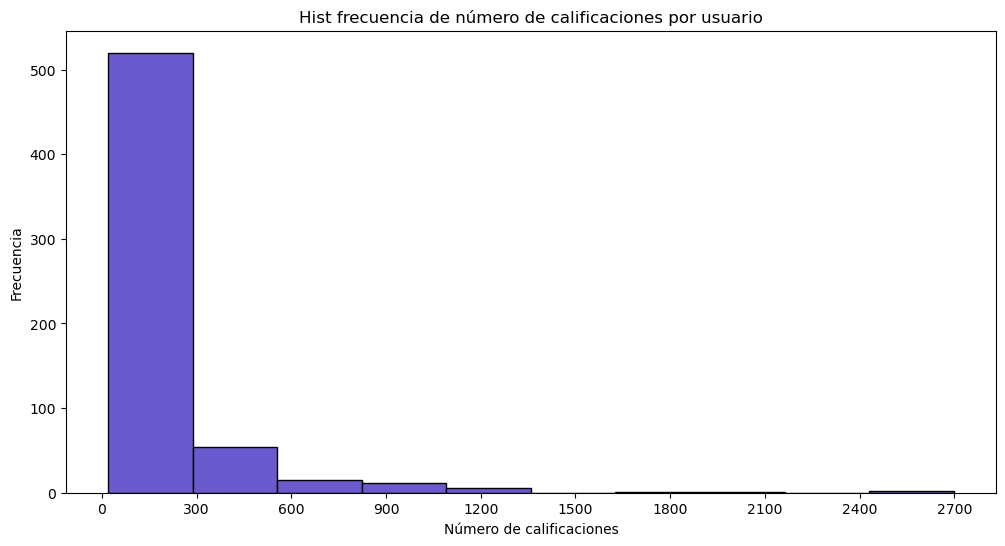

In [10]:
### graficar distribucion despues de filtrar datos
plt.figure(figsize=(12,6))

plt.hist(rating_users['contador_rating'], bins=10, color='slateblue', edgecolor='black')
plt.title('Hist frecuencia de número de calificaciones por usuario')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(0, rating_users['contador_rating'].max()+300, 300))

plt.show()

### Cantidad de calificaciones que tiene cada película

In [11]:
movie_rating=pd.read_sql(''' SELECT m.title, COUNT(r.movieID) as count_rating
                         FROM movies m
                         LEFT JOIN ratings r ON m.movieID = r.movieID
                         GROUP BY m.movieID
                         ORDER BY count_rating DESC;
                         ''',conn )

movie_rating

,title,count_rating
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
...,...,...
9737,I Know Where I'm Going! (1945),0
9738,"Color of Paradise, The (Rang-e khoda) (1999)",0
9739,For All Mankind (1989),0
9740,Niagara (1953),0


In [12]:
movie_rating.describe()

,count_rating
count,9742.000000
mean,10.350647
std,22.384729
min,0.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


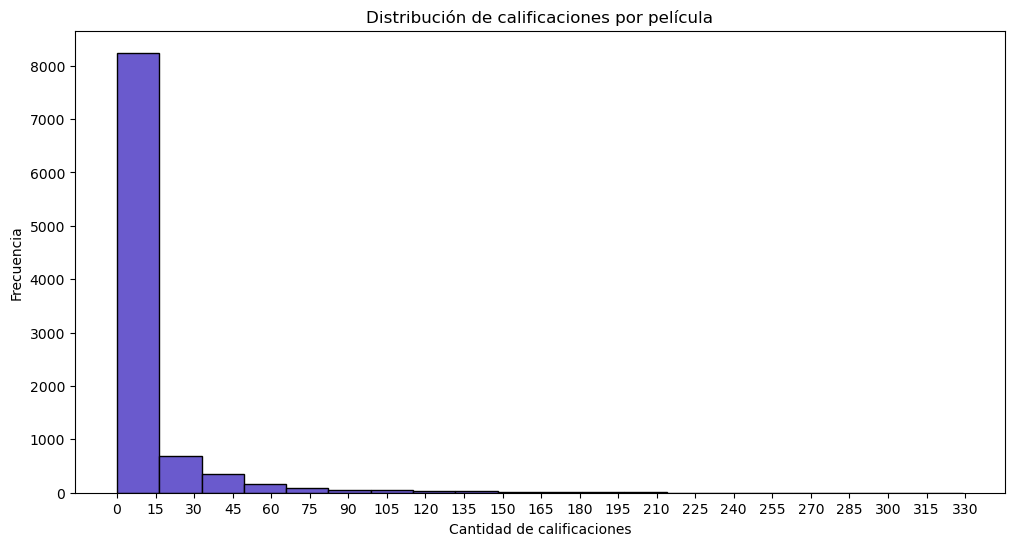

In [13]:
### graficar distribución
plt.figure(figsize=(12, 6))

plt.hist(movie_rating['count_rating'], bins=20, color='slateblue', edgecolor='black')
plt.title('Distribución de calificaciones por película')
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Frecuencia')

plt.xticks(np.arange(0, movie_rating['count_rating'].max() + 15, 15))

plt.show()



### Libros que tienen más de * calificaciones

In [14]:
rating_movie = pd.read_sql("""
                           SELECT m.title,
                           COUNT(r.movieID) as count_rating
                           FROM movies m
                           LEFT JOIN ratings r ON r.movieID = m.movieID
                           GROUP BY m.movieID
                           HAVING count_rating >=50
                           ORDER BY count_rating DESC
                           """, conn)

rating_movie

,title,count_rating
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
...,...,...
445,Scary Movie (2000),50
446,You've Got Mail (1998),50
447,Tron (1982),50
448,Some Like It Hot (1959),50


## Tablas sql

In [15]:
fn.ejecutar_sql('preprocesamiento.sql', cur)

In [16]:
cur.execute("SELECT name from sqlite_master where type = 'table'")
tablas = cur.fetchall()
tablas

[('ratings',),
 ('movies',),
 ('usuarios_sel',),
 ('movies_sel',),
 ('ratings_final',),
 ('movie_final',),
 ('full_ratings',)]

In [17]:
### verficar tamaño de tablas con filtros ####
print(pd.read_sql('select count(*) from ratings', conn))
print(pd.read_sql('select count(*) from ratings_final', conn))

   count(*)
0    100836
   count(*)
0     13168


In [18]:
print(pd.read_sql('select count(*) from movies', conn))
print(pd.read_sql('select count(*) from movie_final', conn))

   count(*)
0      9742
   count(*)
0       134


In [22]:
# tablas cruzadas ###
pd.read_sql('select count(*) from full_ratings', conn)

ratings=pd.read_sql('select * from full_ratings',conn)
ratings.duplicated().sum() ## al cruzar tablas a veces se duplican registros
ratings['movieId'] = ratings['movieId'].astype('object')
ratings['userId'] = ratings['userId'].astype('object')
ratings['rating'] = ratings['rating'].astype('object')
ratings.info()
ratings.head(10)

### tabla de full ratings se utilizara para modelos #####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13168 entries, 0 to 13167
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   userId   13168 non-null  object
 1   movieId  13168 non-null  object
 2   rating   13168 non-null  object
 3   title    13168 non-null  object
 4   genres   13168 non-null  object
dtypes: object(5)
memory usage: 514.5+ KB


,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,6,4.0,Heat (1995),Action|Crime|Thriller
2,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
3,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
4,1,110,4.0,Braveheart (1995),Action|Drama|War
5,1,223,3.0,Clerks (1994),Comedy
6,1,231,5.0,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
7,1,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
8,1,296,3.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
9,1,316,3.0,Stargate (1994),Action|Adventure|Sci-Fi
